In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/LICENSE
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/.gitignore
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/main.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/README.md
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/results.txt
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/solver.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/attn.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/AnomalyTransformer.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/__init__.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/embed.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/utils/utils.py
/kag

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2025-05-19 22:44:50.393232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747694690.638218      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747694690.705701      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')
print("TensorFlow version:", tf.__version__)
print("Environment setup complete.")

TensorFlow version: 2.18.0
Environment setup complete.


In [4]:
data_path = "/kaggle/input/nasa-cmaps/CMaps/"
# If the above path doesn't work, use the alternative:
if not os.path.exists(data_path):
    data_path = "/kaggle/input/nasa-cmaps/cmaps/CMaps/"

print(f"Using data path: {data_path}")

Using data path: /kaggle/input/nasa-cmaps/CMaps/


In [5]:
def load_cmapss_data(data_path, dataset_num=1):
    """
    Load the NASA CMAPSS dataset.
    
    Args:
        data_path: Directory containing CMAPSS data files
        dataset_num: Dataset number (1-4)
        
    Returns:
        train_df: Training dataframe
        test_df: Testing dataframe
        RUL_df: Remaining useful life ground truth
    """
    # Define column names for the data
    columns = ['unit', 'cycle', 'op1', 'op2', 'op3'] + \
              [f'sensor{i}' for i in range(1, 22)]
    
    # Load training data
    train_file = f"train_FD00{dataset_num}.txt"
    train_path = os.path.join(data_path, train_file)
    train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns)
    train_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    test_file = f"test_FD00{dataset_num}.txt"
    test_path = os.path.join(data_path, test_file)
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns)
    test_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    
    # Load RUL ground truth
    rul_file = f"RUL_FD00{dataset_num}.txt"
    rul_path = os.path.join(data_path, rul_file)
    RUL_df = pd.read_csv(rul_path, sep=' ', header=None)
    RUL_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    RUL_df.columns = ['RUL']
    
    print(f"Loaded dataset {dataset_num}:")
    print(f"- Training set: {train_df.shape}")
    print(f"- Test set: {test_df.shape}")
    print(f"- RUL values: {RUL_df.shape}")
    
    return train_df, test_df, RUL_df

In [6]:
train_df, test_df, RUL_df = load_cmapss_data(data_path, dataset_num=1)

Loaded dataset 1:
- Training set: (20631, 24)
- Test set: (13096, 24)
- RUL values: (100, 1)


In [7]:
train_df

unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  \
1   1   -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62   
    2    0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62   
    3   -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62   
    4    0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62   
    5   -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62   
...         ...     ...    ...     ...     ...      ...      ...      ...   
100 196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63    14.62   
    197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58    14.62   
    198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18    14.62   
    199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53    14.62   
    200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14    14.62   

         sensor4  sensor5  ...  sensor10  sensor11  sensor12  sensor13  \
1   1      21.61   554.36  ...    521.66   2388.02   8138.62    8.4195   
    2      21.61   553.75  ...    522.28   2388.07   8131.49    8.4318   
    3      21.61   554.26  ...    522.42   2388.03   8133.23    8.4178   
    4      21.61   554.45  ...    522.86   2388.08   8133.83    8.3682   
    5      21.61   554.00  ...    522.19   2388.04   8133.80    8.4294   
...          ...      ...  ...       ...       ...       ...       ...   
100 196    21.61   551.43  ...    519.49   2388.26   8137.60    8.4956   
    197    21.61   550.86  ...    519.68   2388.22   8136.50    8.5139   
    198    21.61   550.94  ...    520.01   2388.24   8141.05    8.5646   
    199    21.61   550.68  ...    519.67   2388.23   8139.29    8.5389   
    200    21.61   550.79  ...    519.30   2388.26   8137.33    8.5036   

         sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  
1   1        0.03       392      2388     100.0     39.06   23.4190  
    2        0.03       392      2388     100.0     39.00   23.4236  
    3        0.03       390      2388     100.0     38.95   23.3442  
    4        0.03       392      2388     100.0     38.88   23.3739  
    5        0.03       393      2388     100.0     38.90   23.4044  
...           ...       ...       ...       ...       ...       ...  
100 196      0.03       397      2388     100.0     38.49   22.9735  
    197      0.03       395      2388     100.0     38.30   23.1594  
    198      0.03       398      2388     100.0     38.44   22.9333  
    199      0.03       395      2388     100.0     38.29   23.0640  
    200      0.03       396      2388     100.0     38.37   23.0522  

[20631 rows x 24 columns]


Training data sample:
       unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  \
1 1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62   
  2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62   
  3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62   
  4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62   
  5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62   

     sensor4  sensor5  ...  sensor10  sensor11  sensor12  sensor13  sensor14  \
1 1    21.61   554.36  ...    521.66   2388.02   8138.62    8.4195      0.03   
  2    21.61   553.75  ...    522.28   2388.07   8131.49    8.4318      0.03   
  3    21.61   554.26  ...    522.42   2388.03   8133.23    8.4178      0.03   
  4    21.61   554.45  ...    522.86   2388.08   8133.83    8.3682      0.03   
  5    21.61   554.00  ...    522.19   2388.04   8133.80    8.4294      0.03   

     sensor15  sensor16  sensor17  sensor18  sensor19  
1

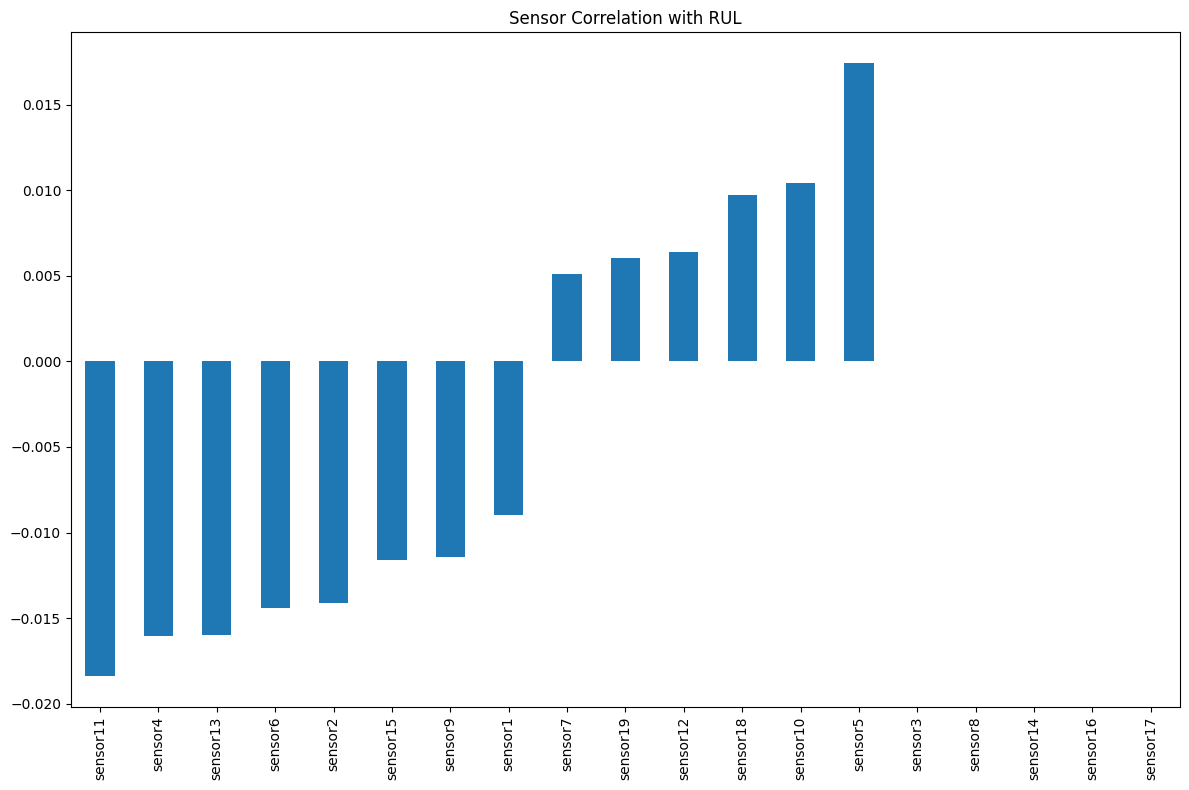


Selected 0 important sensors: []


In [8]:
# Step 4: Explore and preprocess data
# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())

# Add RUL to training data
# Get the maximum cycle for each unit
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']

# Merge with the training data
train_df = train_df.merge(max_cycles, on=['unit'], how='left')

# Calculate RUL (Remaining Useful Life)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Calculate correlation with RUL
correlation = train_df.corr()['RUL'].sort_values()
print("\nCorrelation with RUL:")
print(correlation)

# Visualize correlation with RUL
plt.figure(figsize=(12, 8))
sensor_cols = [col for col in train_df.columns if col.startswith('sensor')]
correlation[sensor_cols].sort_values().plot(kind='bar')
plt.title('Sensor Correlation with RUL')
plt.tight_layout()
plt.show()

# Select important sensors (correlation > 0.1 or < -0.1)
important_sensors = [col for col in sensor_cols if abs(correlation[col]) > 0.1]
print(f"\nSelected {len(important_sensors)} important sensors: {important_sensors}")

# Select features for model training
selected_features = ['cycle'] + important_sensors


Training data sample:
     unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  sensor4  \
0 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62    21.61   
1  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62    21.61   
2 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62    21.61   
3  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62    21.61   
4 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62    21.61   

   sensor5  ...  sensor11  sensor12  sensor13  sensor14  sensor15  sensor16  \
0   554.36  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1   553.75  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2   554.26  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3   554.45  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4   554.00  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor17  sensor18

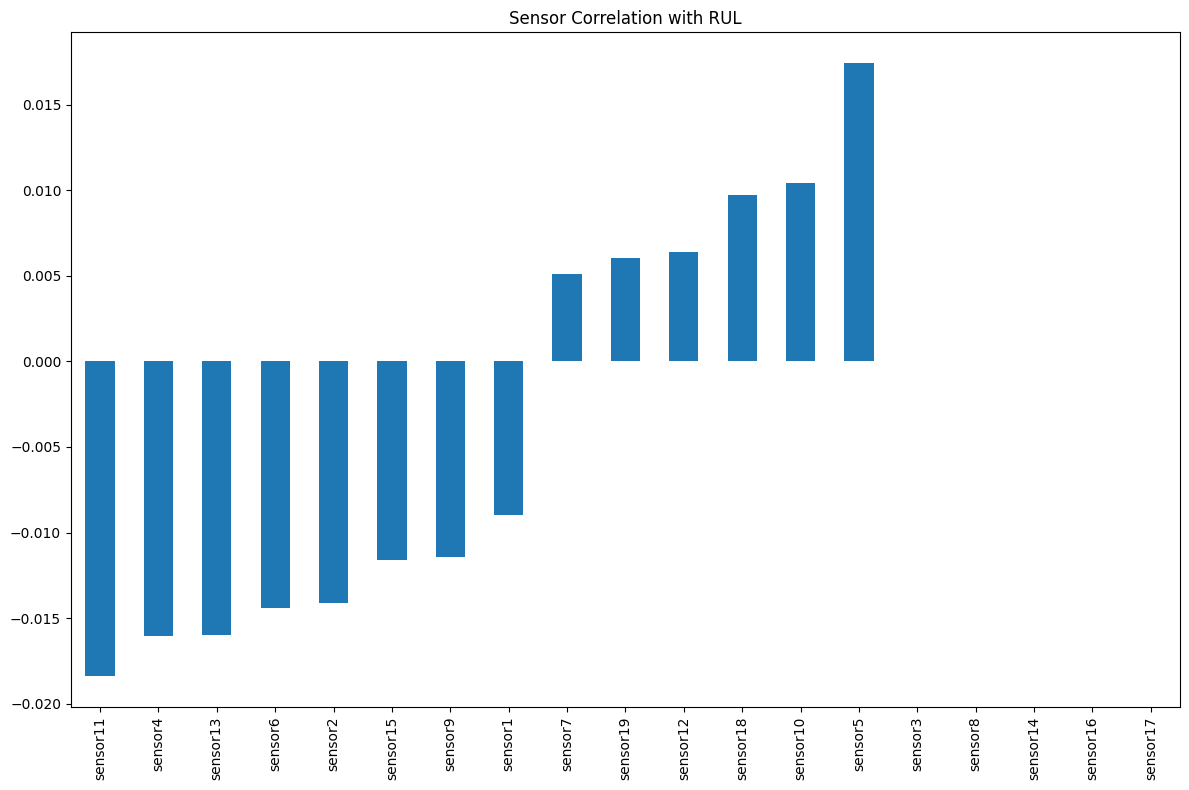


Selected 9 important sensors: ['sensor2', 'sensor4', 'sensor5', 'sensor6', 'sensor9', 'sensor10', 'sensor11', 'sensor13', 'sensor15']
Features used for model training: ['cycle', 'sensor2', 'sensor4', 'sensor5', 'sensor6', 'sensor9', 'sensor10', 'sensor11', 'sensor13', 'sensor15']


In [9]:
# Step 4: Explore and preprocess data
# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())

# Add RUL to training data
# Get the maximum cycle for each unit
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']

# Merge with the training data
train_df = train_df.merge(max_cycles, on=['unit'], how='left')

# Calculate RUL (Remaining Useful Life)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Calculate correlation with RUL
correlation = train_df.corr()['RUL'].sort_values()
print("\nCorrelation with RUL:")
print(correlation)

# Visualize correlation with RUL
plt.figure(figsize=(12, 8))
sensor_cols = [col for col in train_df.columns if col.startswith('sensor')]
correlation[sensor_cols].sort_values().plot(kind='bar')
plt.title('Sensor Correlation with RUL')
plt.tight_layout()
plt.show()

# Select important sensors (correlation > 0.1 or < -0.1)
important_sensors = [col for col in sensor_cols if abs(correlation[col]) > 0.01]
print(f"\nSelected {len(important_sensors)} important sensors: {important_sensors}")

# This is the fix: Only include cycle and the important sensors
selected_features = ['cycle'] + important_sensors
print(f"Features used for model training: {selected_features}")

# Step 5: Normalize the data (with the fix applied)
scaler = MinMaxScaler()

# Only normalize the selected features (not all features)
train_normalized = pd.DataFrame(
    scaler.fit_transform(train_df[selected_features]),
    columns=selected_features
)

# Also normalize test data - only the selected features
test_normalized = pd.DataFrame(
    scaler.transform(test_df[selected_features]),
    columns=selected_features
)

In [10]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define sensor columns (excluding those with NaN correlation)
valid_sensor_cols = correlation[~correlation.isna()].index.tolist()
valid_sensor_cols = [col for col in valid_sensor_cols if col.startswith('sensor')]

# Prepare data
X = train_df[valid_sensor_cols]
y = train_df['RUL']

# Fit a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=valid_sensor_cols)
important_sensors = importances.sort_values(ascending=False).head(10).index.tolist()

# Final selected features
selected_features = ['cycle'] + important_sensors
print(f"Top 10 important sensors based on Random Forest: {important_sensors}")
print(f"Features used for model training: {selected_features}")


Top 10 important sensors based on Random Forest: ['sensor1', 'sensor19', 'sensor13', 'sensor2', 'sensor12', 'sensor5', 'sensor7', 'sensor10', 'sensor18', 'sensor9']
Features used for model training: ['cycle', 'sensor1', 'sensor19', 'sensor13', 'sensor2', 'sensor12', 'sensor5', 'sensor7', 'sensor10', 'sensor18', 'sensor9']


In [11]:
scaler = MinMaxScaler()
train_normalized = pd.DataFrame(
    scaler.fit_transform(train_df[selected_features]),
    columns=selected_features
)

# Also normalize test data
test_normalized = pd.DataFrame(
    scaler.transform(test_df[selected_features]),
    columns=selected_features
)

# Save the unit information for reference
train_units = train_df['unit'].values
test_units = test_df['unit'].values

In [12]:
def create_sequences(data, units, sequence_length=50, step=1):
    """
    Create sequences for time series analysis.
    
    Args:
        data: Normalized data
        units: Unit IDs for each row
        sequence_length: Length of each sequence
        step: Step size for creating sequences
        
    Returns:
        X: Input sequences
        unit_indices: Unit IDs for each sequence
    """
    X = []
    unit_indices = []
    
    # Get unique units
    unique_units = np.unique(units)
    
    for unit in unique_units:
        # Get data for this unit
        unit_data = data[units == unit].values

        for i in range(0, len(unit_data) - sequence_length + 1, step):
            X.append(unit_data[i:i+sequence_length])
            unit_indices.append(unit)
    
    return np.array(X), np.array(unit_indices)


# Create sequences
sequence_length = 50  # You can adjust this
step_size = 10  # You can adjust this

X_train, train_unit_indices = create_sequences(
    train_normalized, 
    train_units,
    sequence_length=sequence_length,
    step=step_size
)

X_test, test_unit_indices = create_sequences(
    test_normalized, 
    test_units,
    sequence_length=sequence_length,
    step=step_size
)
print("\nSequence shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

# Step 7: Split training data into train and validation sets
X_train_split, X_val, train_units_split, val_units = train_test_split(
    X_train, train_unit_indices, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")


Sequence shapes:
X_train: (1583, 50, 11)
X_test: (859, 50, 11)
Training set: (1266, 50, 11)
Validation set: (317, 50, 11)


In [13]:
def build_lstm_autoencoder(input_shape, encoding_dim=32):
    """
    Build an LSTM Autoencoder for anomaly detection.
    
    Args:
        input_shape: Shape of input data (sequence_length, features)
        encoding_dim: Dimension of the encoding layer
        
    Returns:
        model: Compiled LSTM Autoencoder model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(inputs)
    encoded = Dropout(0.2)(encoded)
    encoded = Bidirectional(LSTM(32, activation='relu', return_sequences=False))(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Bottleneck
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)

    decoded = RepeatVector(input_shape[0])(bottleneck)
    decoded = Bidirectional(LSTM(32, activation='relu', return_sequences=True))(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(decoded)
    decoded = Dropout(0.2)(decoded)
    
    # Output layer
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    return model
    
input_shape = X_train_split.shape[1:]

# Build model
model_lstm = build_lstm_autoencoder(input_shape)

# Print model summary
model_lstm.summary()

I0000 00:00:1747694732.947876      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747694732.948577      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 128)             │          38,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 64)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 50, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 11)              │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,315 (649.67 KB)

 Trainable params: 166,315 (649.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1747694774.022304      94 service.cc:148] XLA service 0x44842a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747694774.022895      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747694774.022916      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747694775.977780      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2371  

I0000 00:00:1747694784.906353      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - loss: 0.1476 - val_loss: 0.0306
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0358 - val_loss: 0.0282
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0309 - val_loss: 0.0262
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0278 - val_loss: 0.0243
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0265 - val_loss: 0.0241
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0259 - val_loss: 0.0231
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0254 - val_loss: 0.0232
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0252 - val_loss: 0.0229
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0250 - val_loss: 0.0228
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0247 - val_loss: 0.0228
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0246 - val_loss: 0.0229
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0246 - val

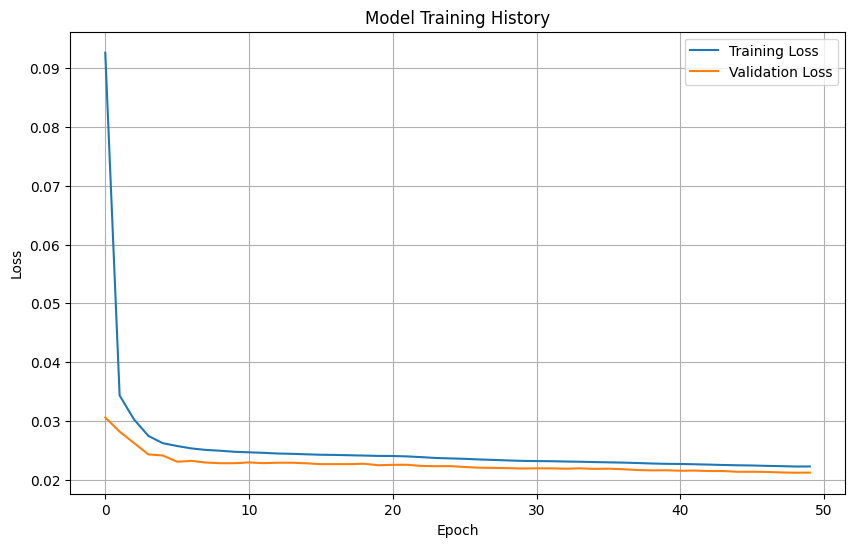

In [14]:
# Step 9: Train the model
# Set callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/lstm_autoencoder.keras',  # ✅ Correct extension
    monitor='val_loss',
    save_best_only=True
)


# Train model
history = model_lstm.fit(
    X_train_split, X_train_split,  # Autoencoder reconstructs its input
    epochs=50,  # You can reduce this for faster training in Kaggle
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Step 10: Detect anomalies in test data
# Get reconstructions
reconstructions = model_lstm.predict(X_test)

# Calculate reconstruction error (MSE) for each sequence
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1, 2))

# Calculate threshold (using 95th percentile of training errors)
# First, get reconstruction errors on training data
train_reconstructions = model_lstm.predict(X_train_split)
train_errors = np.mean(np.square(X_train_split - train_reconstructions), axis=(1, 2))
threshold = np.percentile(train_errors, 95)

print(f"Anomaly threshold: {threshold:.6f}")

# Detect anomalies
anomalies = reconstruction_errors > threshold
max_error = np.max(reconstruction_errors)
severity_scores = reconstruction_errors / max_error

print(f"Detected {sum(anomalies)} anomalies out of {len(anomalies)} test sequences")

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Anomaly threshold: 0.026510
Detected 0 anomalies out of 859 test sequences


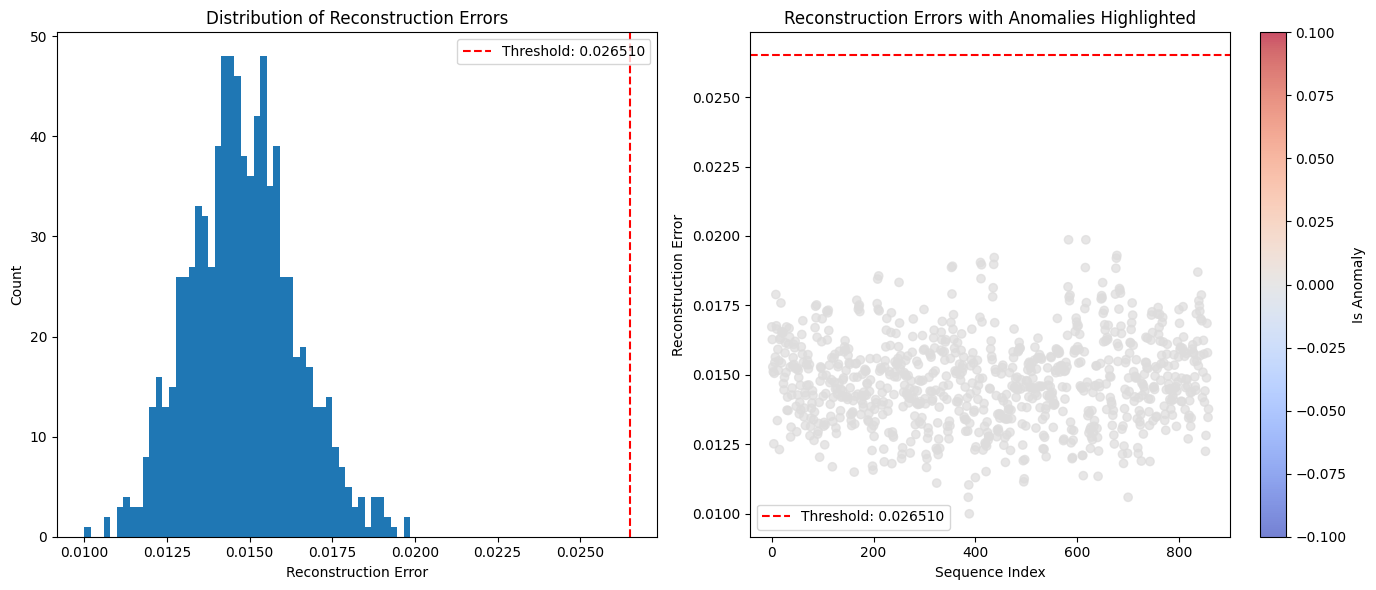

In [16]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, 
           c=anomalies, cmap='coolwarm', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors with Anomalies Highlighted')
plt.colorbar(label='Is Anomaly')
plt.legend()

plt.tight_layout()
plt.show()

Adaptive thresholding detected 28 anomalies


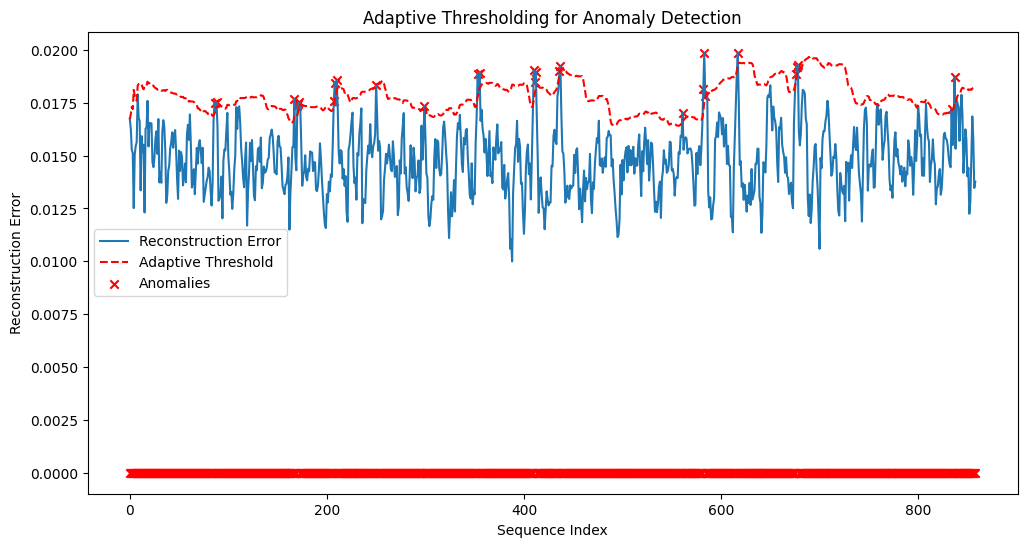

In [17]:
def adaptive_thresholding(errors, window_size=10):
    """
    Apply adaptive thresholding to reconstruction errors.
    
    Args:
        errors: Reconstruction errors
        window_size: Size of the sliding window
        
    Returns:
        thresholds: Threshold values for each point
        anomalies: Boolean array indicating anomalies
    """
    thresholds = []
    anomalies = []
    
    for i in range(len(errors)):
        # Get window of errors
        start = max(0, i - window_size)
        window_errors = errors[start:i+1]
        
        # Calculate adaptive threshold (mean + 2*std)
        window_threshold = window_errors.mean() + 2 * window_errors.std()
        thresholds.append(window_threshold)
        
        # Detect anomaly
        anomalies.append(errors[i] > window_threshold)
    
    return np.array(thresholds), np.array(anomalies)

# Apply adaptive thresholding
adaptive_thresholds, adaptive_anomalies = adaptive_thresholding(reconstruction_errors, window_size=50)

print(f"Adaptive thresholding detected {sum(adaptive_anomalies)} anomalies")

# Visualize adaptive thresholding results
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.plot(adaptive_thresholds, 'r--', label='Adaptive Threshold')
plt.scatter(range(len(reconstruction_errors)), 
           reconstruction_errors * adaptive_anomalies, 
           color='red', marker='x', label='Anomalies')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Adaptive Thresholding for Anomaly Detection')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


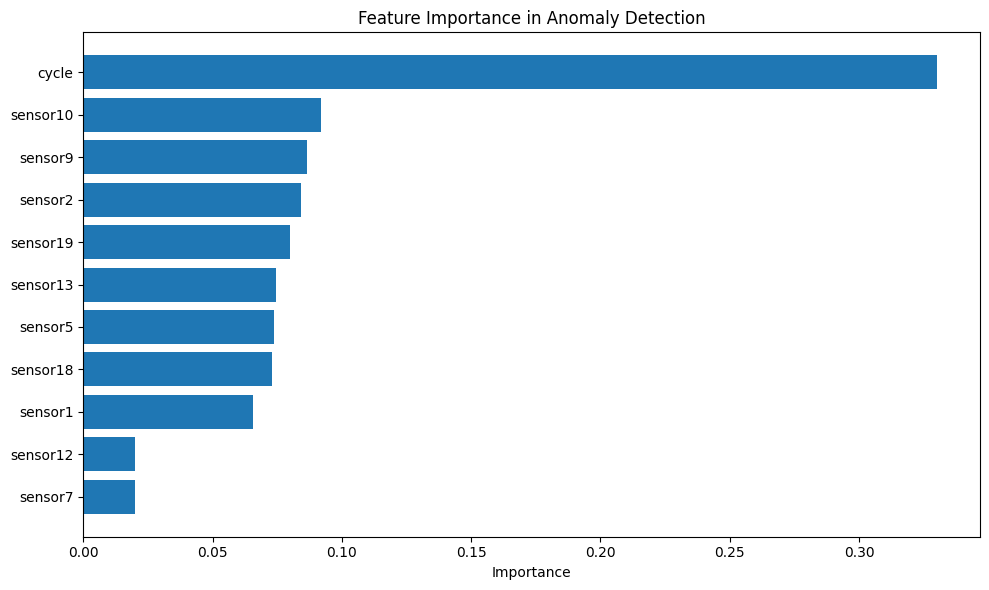

Feature importance for anomalies:
cycle: 0.3303
sensor10: 0.0921
sensor9: 0.0866
sensor2: 0.0841
sensor19: 0.0799
sensor13: 0.0745
sensor5: 0.0739
sensor18: 0.0732
sensor1: 0.0657
sensor12: 0.0199
sensor7: 0.0198


In [18]:
def analyze_feature_importance(model, X, anomaly_indices, selected_features):
    """
    Analyze which features contribute most to anomalies.
    
    Args:
        model: Trained model
        X: Input sequences
        anomaly_indices: Indices of anomalous sequences
        selected_features: Names of selected features
        
    Returns:
        importance_dict: Dictionary of feature importance
    """
    # Select anomalous sequences
    anomalous_sequences = X[anomaly_indices]
    
    # Get reconstructions
    reconstructions = model.predict(anomalous_sequences)
    
    # Calculate error for each feature
    feature_errors = np.mean(np.square(anomalous_sequences - reconstructions), axis=(0, 1))
    
    # Map errors to feature names
    importance_dict = {selected_features[i]: float(feature_errors[i]) 
                      for i in range(len(selected_features))}
    
    # Normalize to get relative importance
    total_importance = sum(importance_dict.values())
    for feature in importance_dict:
        importance_dict[feature] /= total_importance
    
    # Sort by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importance

# Find which features contribute most to anomalies
if sum(adaptive_anomalies) > 0:
    feature_importance = analyze_feature_importance(
        model_lstm, 
        X_test, 
        adaptive_anomalies, 
        selected_features
    )
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features = [x[0] for x in feature_importance]
    importance = [x[1] for x in feature_importance]
    
    plt.barh(features, importance)
    plt.xlabel('Importance')
    plt.title('Feature Importance in Anomaly Detection')
    plt.gca().invert_yaxis()  # Higher importance at the top
    plt.tight_layout()
    plt.show()
    
    print("Feature importance for anomalies:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")
else:
    print("No anomalies detected for feature importance analysis")


Adaptive Threshold: 0.424294
Adaptive Threshold (mean + 3*std): 0.439882


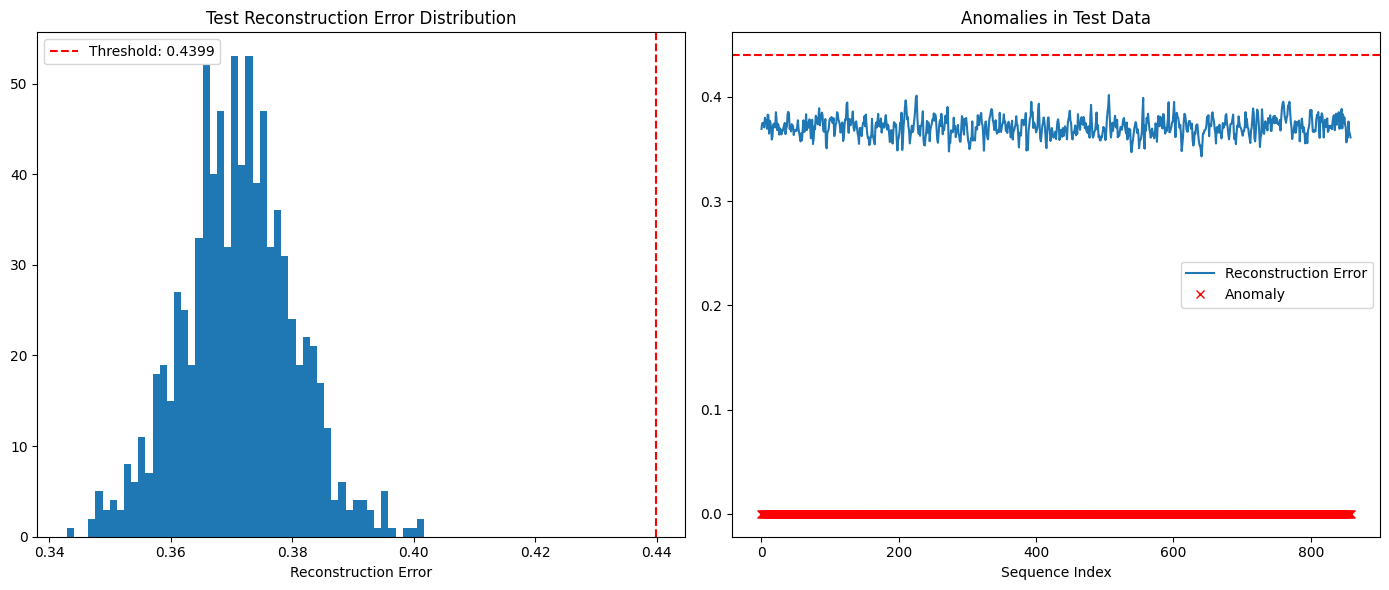

In [19]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os

# Path to the Anomaly Transformer repo
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32

train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load the Anomaly Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],  # sequence length
    enc_in=X_train.shape[2],    # number of features
    c_out=X_train.shape[2],     # same as input
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)

# Load pretrained weights if you have them (optional)
# model.load_state_dict(torch.load("/kaggle/input/...", map_location=device))

# Inference mode
model.eval()

def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # model returns tuple (output, series_assoc, prior_assoc)
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sequence
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute reconstruction errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# Calculate threshold using 95th percentile from train errors
threshold = np.percentile(train_errors, 95)
print(f"Adaptive Threshold: {threshold:.6f}")

# Detect anomalies
mean = np.mean(train_errors)
std = np.std(train_errors)
k = 3  # Sensitivity factor; 2 is more sensitive, 3 is more conservative

threshold = mean + k * std
print(f"Adaptive Threshold (mean + {k}*std): {threshold:.6f}")


# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(test_errors, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.xlabel("Reconstruction Error")
plt.title("Test Reconstruction Error Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_errors, label="Reconstruction Error")
plt.plot(anomalies * test_errors, 'rx', label="Anomaly")
plt.axhline(threshold, color='r', linestyle='--')
plt.title("Anomalies in Test Data")
plt.xlabel("Sequence Index")
plt.legend()

plt.tight_layout()
plt.show()


KDE Adaptive Threshold (log-density): 1.287875
Number of anomalies detected: 43 / 859


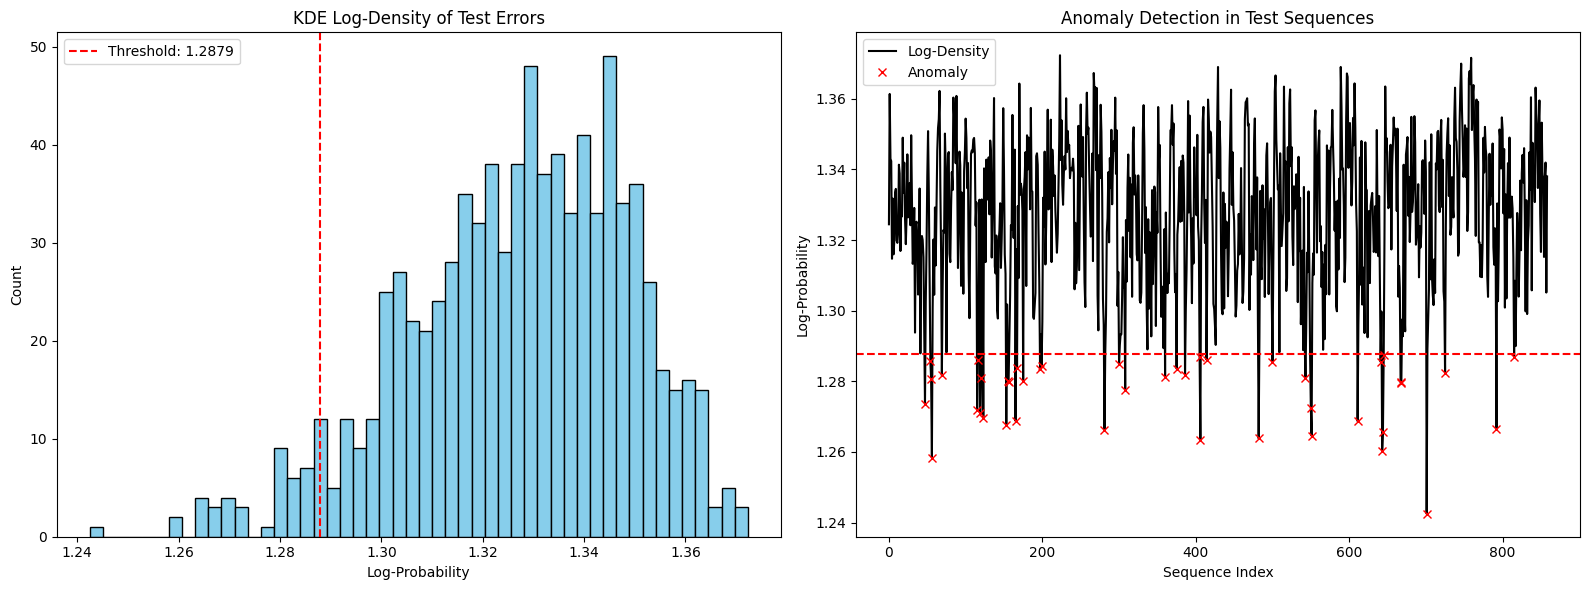

In [20]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Add Anomaly Transformer repo to path
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],
    enc_in=X_train.shape[2],
    c_out=X_train.shape[2],
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)



# Inference mode
model.eval()

# Reconstruction Error Function
def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # Output only
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sample
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# === KDE Thresholding ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(train_errors.reshape(-1, 1))
log_density = kde.score_samples(test_errors.reshape(-1, 1))
threshold = np.percentile(log_density, 5)  # Bottom 5% log-probability
anomalies = log_density < threshold

print(f"KDE Adaptive Threshold (log-density): {threshold:.6f}")
print(f"Number of anomalies detected: {np.sum(anomalies)} / {len(anomalies)}")

# === Visualization ===
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of log-probabilities
plt.subplot(1, 2, 1)
plt.hist(log_density, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("KDE Log-Density of Test Errors")
plt.xlabel("Log-Probability")
plt.ylabel("Count")
plt.legend()

# Plot 2: Sequence with anomalies
plt.subplot(1, 2, 2)
plt.plot(log_density, label='Log-Density', color='black')
plt.plot(np.where(anomalies)[0], log_density[anomalies], 'rx', label='Anomaly')
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Anomaly Detection in Test Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("Log-Probability")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 2.689194
Epoch 2/20, Loss: 0.978976
Epoch 3/20, Loss: 0.419044
Epoch 4/20, Loss: 0.260259
Epoch 5/20, Loss: 0.187331
Epoch 6/20, Loss: 0.145640
Epoch 7/20, Loss: 0.120832
Epoch 8/20, Loss: 0.105169
Epoch 9/20, Loss: 0.094671
Epoch 10/20, Loss: 0.087219
Epoch 11/20, Loss: 0.081824
Epoch 12/20, Loss: 0.077874
Epoch 13/20, Loss: 0.074530
Epoch 14/20, Loss: 0.072014
Epoch 15/20, Loss: 0.069959
Epoch 16/20, Loss: 0.068212
Epoch 17/20, Loss: 0.066746
Epoch 18/20, Loss: 0.065576
Epoch 19/20, Loss: 0.064336
Epoch 20/20, Loss: 0.063391
KDE Adaptive Threshold (log-density): 1.383636
Number of anomalies detected: 43 / 859


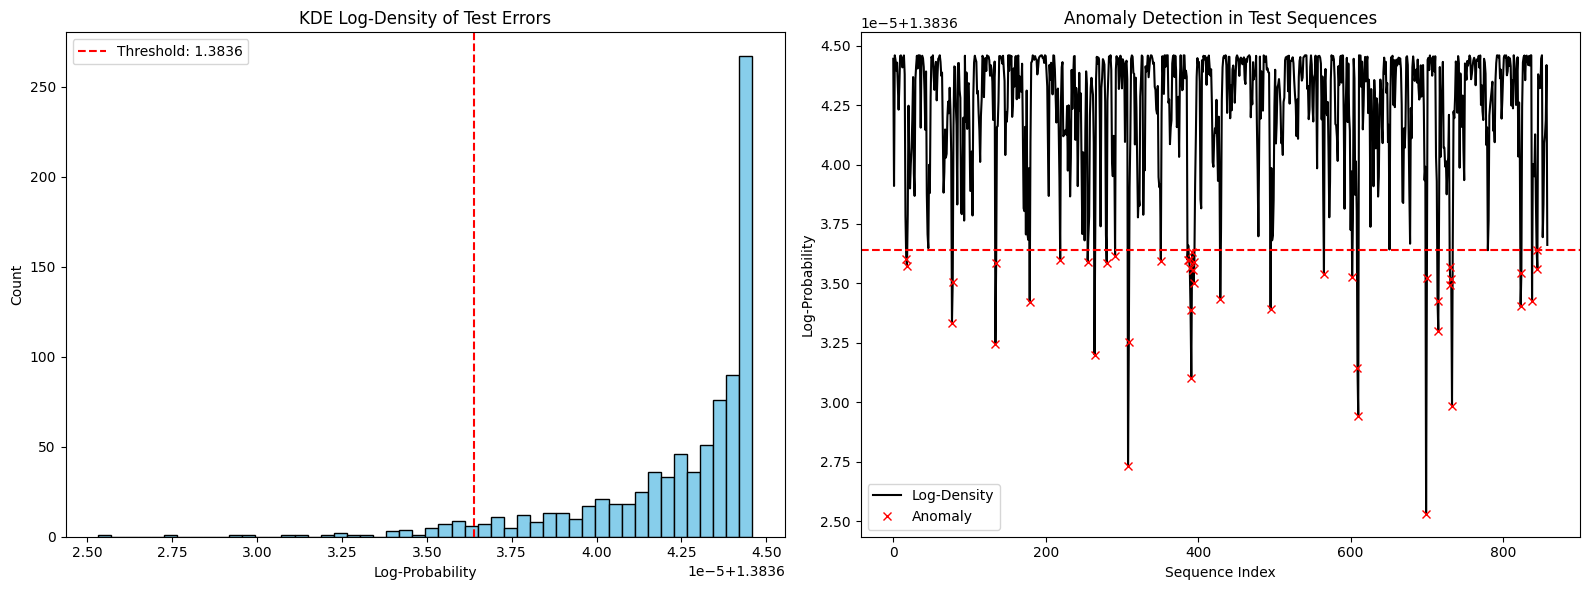

In [21]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Add Anomaly Transformer repo to path
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],
    enc_in=X_train.shape[2],
    c_out=X_train.shape[2],
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)


from torch.optim import Adam
import torch.nn.functional as F

# Define loss function (MSE for reconstruction + optional KL loss if used)
def train_anomaly_transformer(model, dataloader, epochs=10, lr=1e-4):
    optimizer = Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            output, series_list, prior_list, _ = model(batch)

            # Reconstruction loss (MSE)
            rec_loss = F.mse_loss(output, batch)

            # Association discrepancy loss (KL divergence across all heads/layers)
            series_loss = 0.0
            for series, prior in zip(series_list, prior_list):
                kl = series * torch.log((series + 1e-8) / (prior + 1e-8))
                series_loss += torch.mean(torch.sum(kl, dim=-1))

            loss = rec_loss + 0.1 * series_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


# Train the model
train_anomaly_transformer(model, train_loader, epochs=20, lr=1e-4)

# Save model if needed
torch.save(model.state_dict(), "/kaggle/working/anomaly_transformer_trained.pt")

# Inference mode
model.eval()

# Reconstruction Error Function
def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # Output only
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sample
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# === KDE Thresholding ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(train_errors.reshape(-1, 1))
log_density = kde.score_samples(test_errors.reshape(-1, 1))
threshold = np.percentile(log_density, 5)  # Bottom 5% log-probability
anomalies = log_density < threshold

print(f"KDE Adaptive Threshold (log-density): {threshold:.6f}")
print(f"Number of anomalies detected: {np.sum(anomalies)} / {len(anomalies)}")

# === Visualization ===
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of log-probabilities
plt.subplot(1, 2, 1)
plt.hist(log_density, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("KDE Log-Density of Test Errors")
plt.xlabel("Log-Probability")
plt.ylabel("Count")
plt.legend()

# Plot 2: Sequence with anomalies
plt.subplot(1, 2, 2)
plt.plot(log_density, label='Log-Density', color='black')
plt.plot(np.where(anomalies)[0], log_density[anomalies], 'rx', label='Anomaly')
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Anomaly Detection in Test Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("Log-Probability")
plt.legend()

plt.tight_layout()
plt.show()
